## Load libraries

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14.0, 6.0]

import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import os
from sklearn.metrics import confusion_matrix
import pathlib
from IPython.display import Audio, Image, display

## Load code

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_model_and_test_data(ModelPath, train_images_folder):
    ModelData = torch.load(ModelPath,map_location='cpu')
    Input_Resolution = ModelData['resolution']
    SpectrumVariables = ModelData['SpectrumVariables']
    classes = ModelData['classes']
    model = torchvision.models.resnet18()
    model.fc = nn.Linear(512, len(classes))
    model.load_state_dict (ModelData['model'])
    model.cpu()
    model.eval()
    
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize(Input_Resolution),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    full_dataset = torchvision.datasets.ImageFolder(root=train_images_folder, transform=transform)
    full_DataLoader = torch.utils.data.DataLoader(full_dataset, batch_size=4, shuffle=True, num_workers=2)
    train_size = int(0.8 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    torch.manual_seed(0)
    trainset, testset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=False, num_workers=2)
    
    return model, testloader, classes

def create_confusion_matrix(model, testloader, classes):
    # Network analytics
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))
    model.eval()
    allLabels=[]
    allPrediction=[]
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            if (c.dim()==0):
                continue
            for i in range(testloader.batch_size):
                if(len(labels)<=i):
                    continue;
                label = labels[i]
                allLabels.append(labels[i].to('cpu').numpy())
                allPrediction.append(predicted[i].to('cpu').numpy())
                #print (c.shape)
                if(testloader.batch_size>1):

                    class_correct[label] += c[i].item()
                else:
                    class_correct[label] += c.item()
                class_total[label] += 1

    print(confusion_matrix(allLabels, allPrediction))
    for i in range(len(classes)):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))
        
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Print predicted and acual labels for Spectragrams
def print_some(model, testloader, classes):
    dataiter = iter(testloader)
    model.eval()
    for j in range (2):
        images, labels = dataiter.next()
        if device == 'cuda':
            images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        prob, predicted = torch.max(outputs, 1)

        for i in range(len(images)):
            imshow(images[i])
            print('GroundTruth: ',classes[labels[i]])
            print('Predicted: ',  classes[predicted[i]])
            print('Prob: ',  prob[i].detach().numpy())

## Example effects

In [30]:
import glob
import ipywidgets as widgets
style = {'description_width': 'initial'}

SOURCE_DATA_ROOT = '../AudioData/Cats-Vs-Dogs/Dogs/'

def listfiles_nohidden(path):
    return glob.glob(os.path.join(path, '*'))

def listdir_nohidden(path):
    dirs = []
    for gpath in glob.glob(os.path.join(path, '*')):
        if os.path.isdir(gpath):
            dirs.append(gpath)
            dirs.extend(listdir_nohidden(gpath))
    return dirs

SourceFolderDropdown= widgets.Dropdown(options=listfiles_nohidden(SOURCE_DATA_ROOT), description='Source for Training Data:',style=style)
display(SourceFolderDropdown)

Dropdown(description='Source for Training Data:', options=('../AudioData/Cats-Vs-Dogs/Dogs/446370__georra43__d…

../AudioData/Cats-Vs-Dogs_effects/Dogs/446370__georra43__dogs-barking.wav
../GeneratedData/Cats-Vs-Dogs_effects/Dogs/446370__georra43__dogs-barking-0-ch-1.png


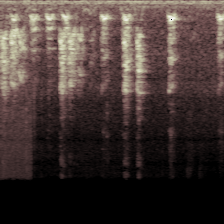

../AudioData/Cats-Vs-Dogs_effects/Dogs/446370__georra43__dogs-barking_delayfb.wav
../GeneratedData/Cats-Vs-Dogs_effects/Dogs/446370__georra43__dogs-barking_delayfb-0-ch-1.png


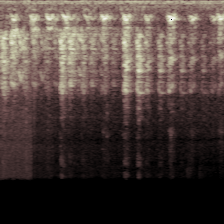

../AudioData/Cats-Vs-Dogs_effects/Dogs/446370__georra43__dogs-barking_delaymod.wav
../GeneratedData/Cats-Vs-Dogs_effects/Dogs/446370__georra43__dogs-barking_delaymod-0-ch-1.png


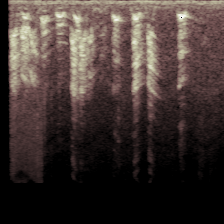

../AudioData/Cats-Vs-Dogs_effects/Dogs/446370__georra43__dogs-barking_distortion.wav
../GeneratedData/Cats-Vs-Dogs_effects/Dogs/446370__georra43__dogs-barking_distortion-0-ch-1.png


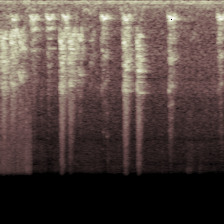

../AudioData/Cats-Vs-Dogs_effects/Dogs/446370__georra43__dogs-barking_reverb.wav
../GeneratedData/Cats-Vs-Dogs_effects/Dogs/446370__georra43__dogs-barking_reverb-0-ch-1.png


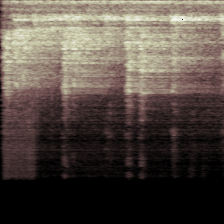

In [31]:
EFFECTS_DATA_ROOT = pathlib.Path('../AudioData/Cats-Vs-Dogs_effects/Dogs/')
EFFECTS_IMG_ROOT = pathlib.Path('../GeneratedData/Cats-Vs-Dogs_effects/Dogs/')

orig_audio_filepath = pathlib.Path(SourceFolderDropdown.value)
effects_audio_files = [
    EFFECTS_DATA_ROOT / orig_audio_filepath.name,
    EFFECTS_DATA_ROOT / (orig_audio_filepath.stem + '_delayfb.wav'),
    EFFECTS_DATA_ROOT / (orig_audio_filepath.stem + '_delaymod.wav'),
    EFFECTS_DATA_ROOT / (orig_audio_filepath.stem + '_distortion.wav'),
    EFFECTS_DATA_ROOT / (orig_audio_filepath.stem + '_reverb.wav')
]
effects_spectrogram_files = [
    EFFECTS_IMG_ROOT / (f.stem + '-0-ch-1.png') for f in effects_audio_files
]
for audio_path, img_path in zip(effects_audio_files, effects_spectrogram_files):
    print(audio_path)
    print(img_path)
    display(Image(img_path))
    display(Audio(audio_path))

## Confusion matrix

In [6]:
orig_model, orig_test, classes = load_model_and_test_data(
    '../models/CatDogResNet.pth', 
    '../GeneratedData/Cats-Vs-Dogs/'
)
effect_model, effect_test, classes = load_model_and_test_data(
    '../models/CatDogResNetEffects.pth', 
    '../GeneratedData/Cats-Vs-Dogs_effects/'
)

In [7]:
create_confusion_matrix(orig_model, orig_test, classes)

[[249  14]
 [  6 211]]
Accuracy of  Cats : 94 %
Accuracy of  Dogs : 97 %


In [8]:
create_confusion_matrix(effect_model, effect_test, classes)

[[792  29]
 [ 60 651]]
Accuracy of  Cats : 96 %
Accuracy of  Dogs : 91 %


In [9]:
create_confusion_matrix(orig_model, effect_test, classes)

[[744  77]
 [ 52 659]]
Accuracy of  Cats : 90 %
Accuracy of  Dogs : 92 %


In [10]:
create_confusion_matrix(effect_model, orig_test, classes)

[[260   3]
 [  8 209]]
Accuracy of  Cats : 98 %
Accuracy of  Dogs : 96 %


In [ ]:
print_some(orig_model, effect_test, classes)